# **Online Shoppers Purchasing Intention**

---

# **Stage 2 - Data Preprocessing**

# Import Library

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

# Machine learning
import sklearn

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
print(f'Scikit-learn {sklearn.__version__}')

Scikit-learn 1.2.2


# Read Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Read file into DataFrame: df
file = '/content/drive/MyDrive/online_shoppers_intention.csv'
df = pd.read_csv(file)

In [5]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [6]:
df.sample(5)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
1369,5,91.833333,0,0.0,32,1480.666667,0.000000,0.006857,0.0,0.0,Mar,1,1,1,3,Returning_Visitor,True,False
10612,9,341.000000,0,0.0,37,1538.950794,0.005128,0.014848,0.0,0.0,Dec,2,2,3,1,Returning_Visitor,False,False
1425,3,221.000000,0,0.0,17,489.583333,0.000000,0.011765,0.0,0.0,Mar,1,1,1,3,New_Visitor,True,False
4554,0,0.000000,1,126.0,45,1340.611199,0.028788,0.028371,0.0,0.0,May,3,2,3,18,Returning_Visitor,False,False
8062,1,43.500000,0,0.0,25,1055.583333,0.007407,0.022840,0.0,0.0,Dec,1,1,1,2,Returning_Visitor,False,False


# 1. Data Cleaning

[Data cleaning](https://www.techtarget.com/searchdatamanagement/definition/data-scrubbing), juga disebut dengan _data scrubbing_, adalah proses memperbaiki data yang salah, tidak lengkap, duplikat, atau lainnya yang salah dalam sebuah dataset. Ini melibatkan identifikasi kesalahan data dan kemudian mengubah, memperbarui, atau menghapus data untuk memperbaikinya.

## 1.0. Check Features

### Melakukan cek fitur

In [7]:
# Before converting
before = df.dtypes

# Convert dtypes: integer to string
for i in ['OperatingSystems', 'Browser', 'Region', 'TrafficType']:
  df[i] = df[i].astype(str)

# Convert dtypes: boolean to integer (binary)
for i in ['Weekend', 'Revenue']:
  df[i] = df[i].astype(int)

# Change target feature name to reduce ambiguity
df = df.rename(columns = {'Revenue' : 'Purchase'})

# After converting
after = df.dtypes

print(f'Sebelum Konversi:\n{before}\n')
print(f'Sesudah Konversi:\n{after}\n')

Sebelum Konversi:
Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

Sesudah Konversi:
Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
Spec

Kita melakukan beberapa perubahan:
- Mengonversi fitur `OperatingSystems`, `Browser`, `Region`, dan `TrafficType` dengan tipe data integer menjadi string, karena selanjutnya akan dilakukan _One-Hot Encoding_.
- Mengonversi fitur dengan tipe data boolean menjadi integer (biner).
- Mengubah nama fitur target `Revenue` menjadi `Purchase` agar tidak menimbulkan ketidakjelasan atau ambiguitas.

### Melakukan penggantian nilai pada fitur `OperatingSystems`
Sumber: https://gs.statcounter.com/os-market-share/all/indonesia

In [8]:
# Melakukan penggantian nilai pada kolom 'OperatingSystems'
# Untuk tipe OS 5 s.d. 8 dimasukkan ke dalam satu tipe OS Other
df['OperatingSystems'] = df['OperatingSystems'].replace(['5', '6', '7', '8'], 'Other')
df['OperatingSystems'] = df['OperatingSystems'].replace({
    '1': 'Windows',
    '2': 'Android',
    '3': 'iOS',
    '4': 'macOS'
})
df['OperatingSystems'].value_counts(normalize = True)

Android    0.535361
Windows    0.209651
iOS        0.207218
macOS      0.038767
Other      0.009002
Name: OperatingSystems, dtype: float64

### Melakukan penggantian nilai pada fitur `Browser`
Sumber: https://gs.statcounter.com/browser-market-share/all/indonesia

In [9]:
# Untuk tipe Browser 6 s.d. 13 dimasukkan ke dalam satu tipe Browser Other
df['Browser'] = df['Browser'].replace(['6', '7', '8', '9', '10', '11', '12', '13'], 'Other')
df['Browser'] = df['Browser'].replace({
    '1': 'Safari',
    '2': 'Chrome',
    '3': 'Other', # Samsung_Internet
    '4': 'Firefox',
    '5': 'Edge'
})
df['Browser'].value_counts(normalize = True)

Chrome     0.645661
Safari     0.199676
Firefox    0.059692
Other      0.057097
Edge       0.037875
Name: Browser, dtype: float64

### Melakukan penggantian nilai pada fitur `Region`
Fitur `Region` diganti dengan Provinsi di Indonesia yang memiliki proporsi individu yang menggunakan internet tertinggi tahun 2019 (data terkini).

Sumber: Badan Pusat Statistik ([BPS - Statistics Indonesia](https://www.bps.go.id/indicator/27/1225/1/proporsi-individu-yang-menggunakan-internet-menurut-provinsi.html))

In [10]:
# Untuk Region dengan proporsi terendah dimasukkan ke dalam 'Region' Other
df['Region'] = df['Region'].replace({
    '1': 'DKI_Jakarta',
    '2': 'Kalimantan_Timur',
    '3': 'Kepulauan_Riau',
    '4': 'DI_Yogyakarta',
    '5': 'Other',
    '6': 'Banten',
    '7': 'Kalimantan_Utara',
    '8': 'Jawa_Barat',
    '9': 'Bali',
})
df['Region'].value_counts(normalize = True)

DKI_Jakarta         0.387672
Kepulauan_Riau      0.194891
DI_Yogyakarta       0.095864
Kalimantan_Timur    0.092133
Banten              0.065288
Kalimantan_Utara    0.061719
Bali                0.041444
Jawa_Barat          0.035199
Other               0.025791
Name: Region, dtype: float64

### Melakukan penggantian nilai pada fitur `TrafficType`

Sumber: https://www.similarweb.com/website/tokopedia.com/#traffic-sources

In [11]:
# Untuk tipe Traffic dengan proporsi rendah dimasukkan ke dalam 'TrafficType' Other
df['TrafficType'] = df['TrafficType'].replace(['5', '7', '8', '9', '11', '12', '14', '15', '16', '17', '18', '19', '20'], 'Other')
df['TrafficType'] = df['TrafficType'].replace({
    '1': 'Organic_Traffic',
    '2': 'Direct_Traffic',
    '3': 'Social_Traffic',
    '4': 'Paid_Traffic',
    '6': 'Display_Advertising',
    '10': 'Email_Marketing',
    '13': 'Referral_Traffic'
})
df['TrafficType'].value_counts(normalize = True)

Direct_Traffic         0.317356
Organic_Traffic        0.198783
Social_Traffic         0.166423
Other                  0.098378
Paid_Traffic           0.086699
Referral_Traffic       0.059854
Email_Marketing        0.036496
Display_Advertising    0.036010
Name: TrafficType, dtype: float64

### Melakukan penggantian nilai pada fitur `VisitorType`

In [12]:
df['VisitorType'].value_counts(normalize = True)

Returning_Visitor    0.855718
New_Visitor          0.137388
Other                0.006894
Name: VisitorType, dtype: float64

In [13]:
# Transform 'Other' Value to 'Returning_Visitor'
df['VisitorType'] = np.where(df['VisitorType'] == 'New_Visitor', 1, 0 )
df['VisitorType'].value_counts(normalize = True)

0    0.862612
1    0.137388
Name: VisitorType, dtype: float64

### Mengelompokkan fitur

In [14]:
# Feature Grouping
num_var = ['Administrative', 'Administrative_Duration',
           'Informational', 'Informational_Duration',
           'ProductRelated', 'ProductRelated_Duration',
           'BounceRates', 'ExitRates',
           'PageValues', 'SpecialDay']
cat_var = ['Month', 'OperatingSystems',
           'Browser', 'Region',
           'TrafficType', 'VisitorType',
           'Weekend']
target = 'Purchase'

## 1.1. Handle Missing Values

In [15]:
# Check Missing Values
print(f'Jumlah total nilai kosong dalam dataset: {df.isna().sum().sum()}')

Jumlah total nilai kosong dalam dataset: 0


- Dataset ini bersih, tidak memiliki nilai kosong.

## 1.2. Handle Duplicated Data

In [16]:
# Check Duplicated Data
print(f'Jumlah total duplikat dalam dataset: {df.duplicated().sum()}')

Jumlah total duplikat dalam dataset: 128


- Dataset ini memiliki data duplikat sebanyak 128 baris. Walaupun demikian, kita berasumsi bahwa data tersebut merupakan data unik, yang terkait dengan sesi kunjungan pelanggan, sehingga kita tidak _handle_ data tersebut.

## 1.3. Handle Outliers

### 1.3.0. Splitting Dataset into Train and Test sets

Sebelum melakukan _handling outlier_, kita melakukan _splitting dataset_ menjadi train dan test set. Kita hanya melakukan _handling outlier_ pada data **_train_** dan selanjutnya melakukan evaluasi performa model pada data **_test_**.

In [17]:
X = df[num_var + cat_var]
y = df[target]

# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 400)

# Check the shapes
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of X_test : {X_test.shape}')
print(f'Shape of y_test : {y_test.shape}')

Shape of X_train: (9864, 17)
Shape of y_train: (9864,)
Shape of X_test : (2466, 17)
Shape of y_test : (2466,)


In [18]:
X.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend'],
      dtype='object')

### 1.3.1. Handling Outlier

Kami menggunakan metode Z-Score untuk menghapus data _outlier_ ekstrem pada **X_train** set.

In [19]:
from scipy import stats

print(f'Jumlah baris sebelum memfilter outlier: {len(X_train)}')
col = X_train[num_var].columns
for col in num_var:
    # Menghitung z-score untuk setiap data pada kolom
    z_scores = stats.zscore(X_train[col])
    
    # Menentukan batas atas dan bawah untuk outlier
    k = 3
    outlier_upper = X_train[col].mean() + k * X_train[col].std()
    outlier_lower = X_train[col].mean() - k * X_train[col].std()
    
    # Mengubah nilai outlier dengan nilai min atau max
    X_train.loc[z_scores > k, col] = outlier_upper
    X_train.loc[z_scores < -k, col] = outlier_lower

print(f'Jumlah baris sesudah memfilter outlier: {len(X_train)}')

Jumlah baris sebelum memfilter outlier: 9864
Jumlah baris sesudah memfilter outlier: 9864


In [20]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Administrative,9864.0,2.256527,3.106233,0.0,0.000000,1.000000,4.000000,12.266580
Administrative_Duration,9864.0,73.289617,127.858668,0.0,0.000000,7.000000,92.100379,614.642535
Informational,9864.0,0.449369,1.021815,0.0,0.000000,0.000000,0.000000,4.279875
Informational_Duration,9864.0,26.598905,83.776893,0.0,0.000000,0.000000,0.000000,456.866299
ProductRelated,9864.0,30.009194,34.557481,0.0,7.000000,18.000000,38.000000,163.798308
ProductRelated_Duration,9864.0,1126.539813,1432.521879,0.0,187.000000,605.808333,1470.881445,6930.199571
BounceRates,9864.0,0.020147,0.041483,0.0,0.000000,0.003070,0.016787,0.166823
ExitRates,9864.0,0.042278,0.046271,0.0,0.014286,0.025401,0.050000,0.188231
PageValues,9864.0,5.016260,13.027800,0.0,0.000000,0.000000,0.000000,60.550726
SpecialDay,9864.0,0.055153,0.170220,0.0,0.000000,0.000000,0.000000,0.664855


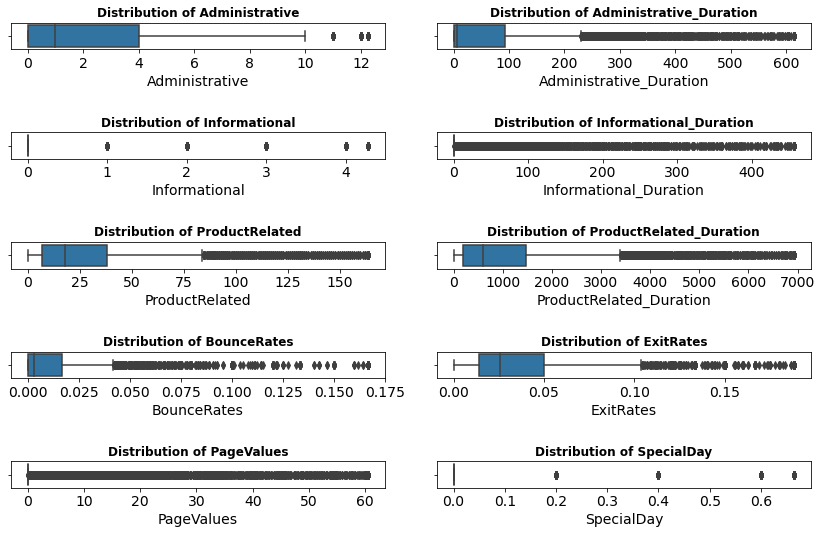

In [21]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rcParams['figure.figsize'] = (12,8)
matplotlib.rcParams['font.size'] = 14

df_num = X_train[num_var].columns

for i in range(0, len(df_num)):
    plt.subplot(5, 2, i + 1)
    sns.boxplot(x = X_train[df_num[i]],
                orient = 'h')
    plt.title('Distribution of ' + df_num[i],
              fontsize = 12,
              fontweight = 'bold')
    plt.tight_layout(pad = 2)

plt.show()

## 1.4. Feature Transformation

Kami menggunakan _Logarithmic Transformation_ untuk mengubah fitur numerikal terdistribusi menceng ke kanan menjadi terdistribusi lebih normal.

In [22]:
# Melihat skewness dari setiap fitur sesudah log transformasi
skewness = pd.DataFrame({'skewness': np.abs(X_train.skew())})
print(skewness)

                         skewness
Administrative           1.532980
Administrative_Duration  2.502657
Informational            2.431558
Informational_Duration   3.914098
ProductRelated           2.101074
ProductRelated_Duration  2.203411
BounceRates              2.751998
ExitRates                2.051905
PageValues               3.021365
SpecialDay               2.940334
VisitorType              2.107202
Weekend                  1.259561


- Dari output di atas, kita dapat melihat bahwa semua fitur numerikal memiliki _skewness_ yang tinggi (nilai absolut dari skewness > 1), sehingga perlu di-log transformasi.

In [23]:
# Log transformasi pada fitur numerikal dengan skewness tinggi
cols = ['Administrative', 'Administrative_Duration',
        'Informational', 'Informational_Duration',
        'ProductRelated', 'ProductRelated_Duration',
        'BounceRates', 'ExitRates',
        'PageValues', 'SpecialDay']

for col in cols:
    X_train[col] = np.log(X_train[col] + 1)

Kita menggunakan fungsi `np.log` untuk melakukan log transformasi pada variabel, dan menambahkan 1 untuk menghindari pembagian dengan nol. Setelah transformasi selesai, kita dapat memeriksa skewness kembali untuk memastikan bahwa nilai skewness sudah berkurang.

In [24]:
# Melihat skewness dari setiap fitur sesudah log transformasi
skewness = pd.DataFrame({'skewness': np.abs(X_train.skew())})
print(skewness)

                         skewness
Administrative           0.538036
Administrative_Duration  0.237225
Informational            1.868113
Informational_Duration   1.882582
ProductRelated           0.153651
ProductRelated_Duration  1.470738
BounceRates              2.690427
ExitRates                1.964926
PageValues               1.754545
SpecialDay               2.876233
VisitorType              2.107202
Weekend                  1.259561


In [25]:
num = X_train[num_var].columns

# Check Statistical Descriptive
X_train[num[:-1]].describe().T[['min']]

,min
Administrative,0.0
Administrative_Duration,0.0
Informational,0.0
Informational_Duration,0.0
ProductRelated,0.0
ProductRelated_Duration,0.0
BounceRates,0.0
ExitRates,0.0
PageValues,0.0


Setelah itu, kami menggunakan _Min Max Scaler_ untuk menormalisasi data numerikal dalam rentang 0–1.

In [26]:
from sklearn.preprocessing import MinMaxScaler

# Membuat objek Min Max Scaler
scaler = MinMaxScaler()

# Melakukan normalisasi pada data numerik
X_train[num_var] = scaler.fit_transform(X_train[num_var])

In [27]:
X_train[['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']].describe().T

,count,unique,top,freq
Month,9864,10,May,2698
OperatingSystems,9864,5,Android,5299
Browser,9864,5,Chrome,6411
Region,9864,9,DKI_Jakarta,3837
TrafficType,9864,8,Direct_Traffic,3085


In [28]:
X_train[cat_var].describe().T

,count,mean,std,min,25%,50%,75%,max
VisitorType,9864.0,0.137368,0.344253,0.0,0.0,0.0,0.0,1.0
Weekend,9864.0,0.233577,0.423127,0.0,0.0,0.0,0.0,1.0


## 1.5. Feature Encoding

Kita akan melakukan _feature encoding_ terhadap fitur `Month`, `OperatingSystems`, `Browser`, `Region`, dan `TrafficType` menggunakan _One-Hot Encoding_. Namun, sebelumnya, nilai masing-masing fitur diubah terlebih dahulu menjadi nilai yang lebih mudah dipahami.

In [29]:
# Untuk 'June' diubah menjadi 'Jun' agar lebih seragam
X_train['Month'] = X_train['Month'].replace('June', 'Jun')
X_train['Month'].unique()

array(['May', 'Dec', 'Nov', 'Aug', 'Mar', 'Feb', 'Sep', 'Oct', 'Jul',
       'Jun'], dtype=object)

### One-Hot Encoding

In [30]:
# Melakukan one-hot encoding terhadap 'VisitorType'
X_train = pd.get_dummies(X_train, columns = ['Month', 'OperatingSystems',
                                             'Browser', 'Region', 'TrafficType'])
print(f'Jumlah fitur sesudah encoding: {X_train.shape[1]}')

Jumlah fitur sesudah encoding: 49


In [31]:
X_train.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'VisitorType',
       'Weekend', 'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul',
       'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct',
       'Month_Sep', 'OperatingSystems_Android', 'OperatingSystems_Other',
       'OperatingSystems_Windows', 'OperatingSystems_iOS',
       'OperatingSystems_macOS', 'Browser_Chrome', 'Browser_Edge',
       'Browser_Firefox', 'Browser_Other', 'Browser_Safari', 'Region_Bali',
       'Region_Banten', 'Region_DI_Yogyakarta', 'Region_DKI_Jakarta',
       'Region_Jawa_Barat', 'Region_Kalimantan_Timur',
       'Region_Kalimantan_Utara', 'Region_Kepulauan_Riau', 'Region_Other',
       'TrafficType_Direct_Traffic', 'TrafficType_Display_Advertising',
       'TrafficType_Email_Marketing', 'TrafficType_Organic_Traffic',
       'TrafficT

In [32]:
print('Jumlah baris: {}'.format(X_train.shape[0]))
print('Jumlah kolom: {}'.format(X_train.shape[1]))

Jumlah baris: 9864
Jumlah kolom: 49


## 1.6. Handle Class Imbalance

Terakhir, kami menggunakan metode Random Over-Sampling untuk _handle_ fitur target yang tidak seimbang dengan menambahkan jumlah sample pada minority class sehingga setara dengan majority class

In [33]:
from imblearn.over_sampling import RandomOverSampler

# Random Over Sampling
oversampler = RandomOverSampler(random_state=400)
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)
print(pd.Series(y_resampled).value_counts())


0    8350
1    8350
Name: Purchase, dtype: int64


# 2. Feature Engineering

## 2.0. Check Features

In [34]:
print(f'Sesudah Konversi:\n{X_resampled.dtypes}\n')

Sesudah Konversi:
Administrative                     float64
Administrative_Duration            float64
Informational                      float64
Informational_Duration             float64
ProductRelated                     float64
ProductRelated_Duration            float64
BounceRates                        float64
ExitRates                          float64
PageValues                         float64
SpecialDay                         float64
VisitorType                          int64
Weekend                              int64
Month_Aug                            uint8
Month_Dec                            uint8
Month_Feb                            uint8
Month_Jul                            uint8
Month_Jun                            uint8
Month_Mar                            uint8
Month_May                            uint8
Month_Nov                            uint8
Month_Oct                            uint8
Month_Sep                            uint8
OperatingSystems_Android            

In [35]:
X = X_resampled
y = y_resampled
print(X.shape, y.shape)
print(f'X = {X.shape[0]} baris\ny = {y.shape[0]} baris')

(16700, 49) (16700,)
X = 16700 baris
y = 16700 baris


In [36]:
# Concat X_resampled dan y_resampled menjadi df_cleaned
df_cleaned = pd.concat([X_resampled, y_resampled], axis=1)
df_cleaned.sample(5)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,VisitorType,Weekend,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,OperatingSystems_Android,OperatingSystems_Other,OperatingSystems_Windows,OperatingSystems_iOS,OperatingSystems_macOS,Browser_Chrome,Browser_Edge,Browser_Firefox,Browser_Other,Browser_Safari,Region_Bali,Region_Banten,Region_DI_Yogyakarta,Region_DKI_Jakarta,Region_Jawa_Barat,Region_Kalimantan_Timur,Region_Kalimantan_Utara,Region_Kepulauan_Riau,Region_Other,TrafficType_Direct_Traffic,TrafficType_Display_Advertising,TrafficType_Email_Marketing,TrafficType_Organic_Traffic,TrafficType_Other,TrafficType_Paid_Traffic,TrafficType_Referral_Traffic,TrafficType_Social_Traffic,Purchase
7506,0.424954,0.660592,0.0,0.0,0.469741,0.637456,0.000000,0.190124,0.000000,0.000000,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
4425,0.927530,0.822587,0.0,0.0,0.750020,0.774165,0.080517,0.091879,0.000000,0.000000,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
13326,0.804349,0.626304,1.0,1.0,0.596413,0.675886,0.175084,0.193463,0.000000,0.000000,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3562,0.693071,0.549049,0.0,0.0,0.785025,0.849792,0.024413,0.065272,0.000000,0.000000,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
15301,0.000000,0.000000,0.0,0.0,0.407356,0.770048,0.000000,0.095841,0.672728,0.660089,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1


In [37]:
data = df_cleaned
# Assign X and y
X = data.drop('Purchase', axis = 1)
y = data['Purchase']

## 2.0. Feature Importance

### Logistic Regression Feature Importance

Feature: Administrative, Score: -0.21
Feature: Administrative_Duration, Score: 0.19
Feature: Informational, Score: 0.84
Feature: Informational_Duration, Score: -0.49
Feature: ProductRelated, Score: 1.57
Feature: ProductRelated_Duration, Score: -1.50
Feature: BounceRates, Score: -1.38
Feature: ExitRates, Score: -1.14
Feature: PageValues, Score: 5.28
Feature: SpecialDay, Score: 0.20
Feature: VisitorType, Score: 0.39
Feature: Weekend, Score: 0.03
Feature: Month_Aug, Score: 0.44
Feature: Month_Dec, Score: -0.29
Feature: Month_Feb, Score: -1.39
Feature: Month_Jul, Score: 0.54
Feature: Month_Jun, Score: 0.11
Feature: Month_Mar, Score: -0.59
Feature: Month_May, Score: -0.95
Feature: Month_Nov, Score: 1.25
Feature: Month_Oct, Score: 0.04
Feature: Month_Sep, Score: 0.85
Feature: OperatingSystems_Android, Score: 0.05
Feature: OperatingSystems_Other, Score: 0.52
Feature: OperatingSystems_Windows, Score: -0.21
Feature: OperatingSystems_iOS, Score: -0.13
Feature: OperatingSystems_macOS, Score: -0.2

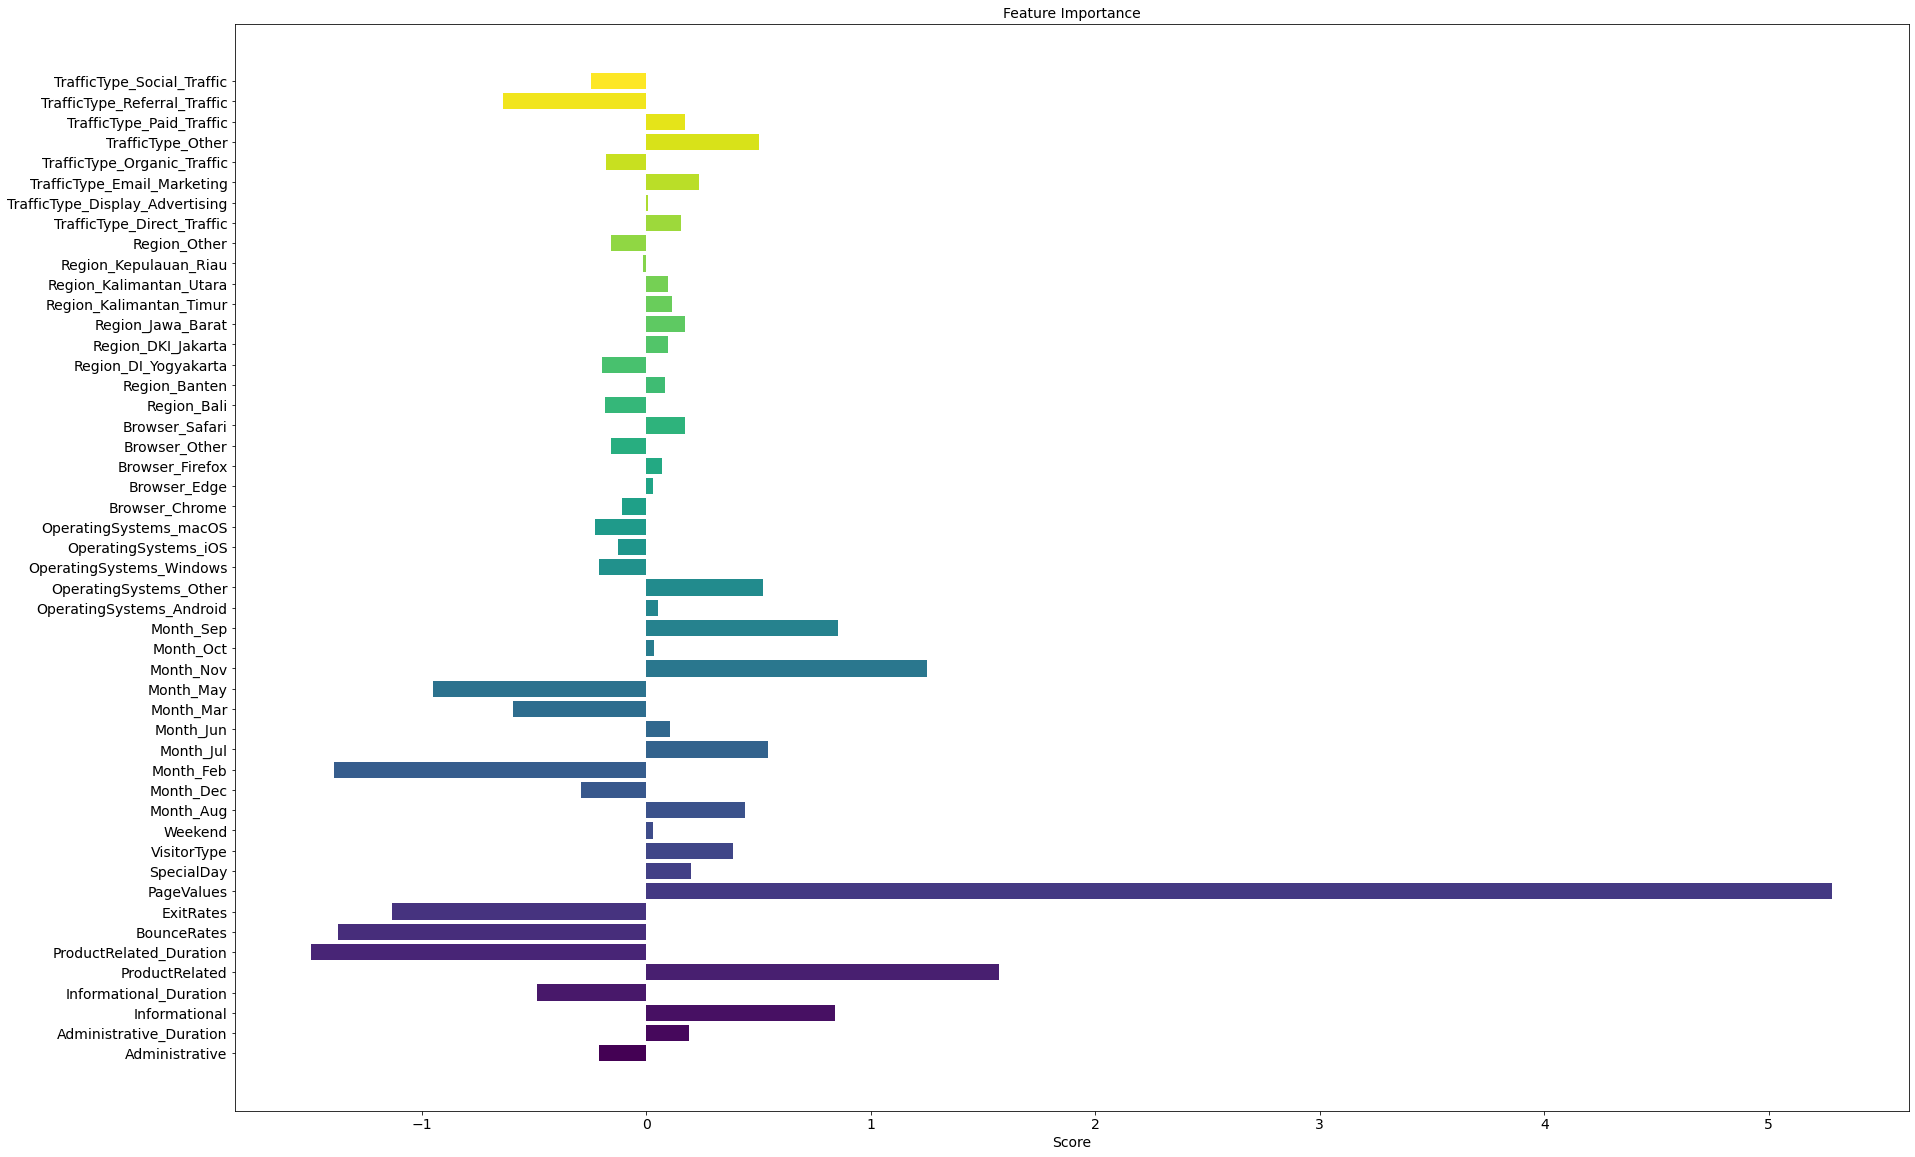

In [38]:
from sklearn.linear_model import LogisticRegression

# Define dataset
data = df_cleaned
# Assign X and y
X = data.drop('Purchase', axis = 1)
y = data['Purchase']

# Define and fit the model
model = LogisticRegression()
model.fit(X, y)
# Get importance
importance = model.coef_[0]

# Summarize feature importance
for i, col in enumerate(X.columns):
    print('Feature: %s, Score: %.2f' % (col, importance[i]))
print('')

fig, ax = plt.subplots(figsize = (30, 20))
cmap = plt.get_cmap('viridis')
bars = ax.barh([x for x in range(len(importance))], importance, color = cmap(np.linspace(0, 1, len(importance))))
ax.set_yticks(np.arange(len(importance)))
ax.set_yticklabels(X.columns, ha = 'right')
ax.set_title('Feature Importance', fontsize = 14)
ax.set_xlabel('Score')
plt.show()

Berdasarkan hasil dari Logistic Regression,
- Fitur-fitur yang memiliki pengaruh positif terbesar dalam memprediksi target adalah:
  - Fitur `PageValues` dengan koefisien sebesar 5,28, diikuti oleh `Month_Nov`, `Informational`, `Month_Jul`, `Month_Sep`, dan `ProductRelated`, sedangkan
- Fitur-fitur yang memiliki pengaruh negatif terbesar adalah:
  - Fitur `Month_Feb` dengan koefisien sebesar -1,39, diikuti oleh `BounceRates`, `Month_May`, `Month_Mar`, `Region_Other`, dan `ExitRates`.

Note:
- Skor positif menunjukkan fitur yang memprediksi label 1 (Purchase), sedangkan skor negatif menunjukkan fitur yang memprediksi label 0 (Not Purchase).

## 2.1. Feature Selection

_Feature selection_ adalah suatu proses memilih fitur yang relevan dengan cara membuang fitur yang tidak relevan terhadap target sebelum dimasukkan ke dalam _machine learning model_. Proses ini sangat penting dalam pengembangan _machine learning model_ karena berpengaruh pada akurasi dan performa model.



### 2.1.1. Chi-Square

In [39]:
from sklearn.feature_selection import SelectKBest, chi2

# Define dataset
data = df_cleaned
# Assign X and y
X = data.drop('Purchase', axis = 1)
y = data['Purchase']

# Result count
k = 20

# Perform chi-square test
bestfeatures = SelectKBest(score_func = chi2) 
fit = bestfeatures.fit(X, y)

# New df: columns and scores
df_columns = pd.DataFrame(X.columns)
df_scores = pd.DataFrame(fit.scores_)

# Concat two df
featureScores = pd.concat([df_columns, df_scores], axis = 1)
featureScores.columns = ['Feature', 'Score']

print(featureScores.nlargest(k, 'Score'))

                         Feature        Score
8                     PageValues  3430.022674
6                    BounceRates   582.825405
19                     Month_Nov   492.651718
7                      ExitRates   482.110315
1        Administrative_Duration   293.424185
0                 Administrative   255.644968
10                   VisitorType   248.167822
41    TrafficType_Direct_Traffic   224.591484
9                     SpecialDay   216.305325
3         Informational_Duration   213.802577
2                  Informational   200.605920
48    TrafficType_Social_Traffic   193.143281
47  TrafficType_Referral_Traffic   192.533333
25          OperatingSystems_iOS   163.636697
18                     Month_May   160.400000
44   TrafficType_Organic_Traffic   142.125517
17                     Month_Mar   126.412836
14                     Month_Feb   102.092025
4                 ProductRelated    99.784181
45             TrafficType_Other    99.691040


Dari hasil _feature selection_ menggunakan metode _Chi-Square_, fitur-fitur yang memiliki score tertinggi, yaitu:
- `PageValues` memiliki score paling dominan, yaitu 3430.
- `Month_Nov` dan `Month_Mar` dapat memprediksi, karena pada bulan-bulan tersebut memiliki kecenderungan dilakukan pembelian atau `Purchase`.
- `Administrative_Duration` dan `Administrative` dapat memprediksi, karena ketika makin lama durasi atau waktu yang dihabiskan pada suatu halaman, maka makin besar kemungkinan `Purchase`.
- `TrafficType_Direct_Traffic` dapat memprediksi, karena ketika melalui situs web utama, maka makin besar kemungkinan `Purchase`.
- `ExitRates` dan `BounceRates` dapat memprediksi pelanggan itu melakukan `Purchase` atau tidak, karena ketika nilai Exit Rates atau Bounce Rates yang rendah, maka makin besar kemungkinan terjadi `Purchase`.
- `VisitorType_New_Visitor` dapat memprediksi, karena tipe pelanggan dapat juga memengaruhi _Purchase Rate_.
- Fitur yang lain dapat dipertimbangkan untuk dihapus.

In [40]:
keep_chi = featureScores.nlargest(20, 'Score') # Top 20 features
list_chi = keep_chi['Feature'].unique()
list_chi

array(['PageValues', 'BounceRates', 'Month_Nov', 'ExitRates',
       'Administrative_Duration', 'Administrative', 'VisitorType',
       'TrafficType_Direct_Traffic', 'SpecialDay',
       'Informational_Duration', 'Informational',
       'TrafficType_Social_Traffic', 'TrafficType_Referral_Traffic',
       'OperatingSystems_iOS', 'Month_May', 'TrafficType_Organic_Traffic',
       'Month_Mar', 'Month_Feb', 'ProductRelated', 'TrafficType_Other'],
      dtype=object)

In [41]:
drop_chi = featureScores.nsmallest(29, 'Score') # Bottom 29 features
list_drop_chi = drop_chi['Feature'].unique()
list_drop_chi

array(['Region_Kalimantan_Utara', 'Browser_Safari', 'Browser_Other',
       'Browser_Chrome', 'Region_Banten', 'TrafficType_Paid_Traffic',
       'Region_Other', 'OperatingSystems_Windows',
       'OperatingSystems_Other', 'Region_Jawa_Barat', 'Month_Aug',
       'Region_Bali', 'Region_Kalimantan_Timur', 'Month_Jul',
       'Region_Kepulauan_Riau', 'Browser_Firefox',
       'OperatingSystems_macOS', 'Region_DKI_Jakarta',
       'TrafficType_Display_Advertising', 'Browser_Edge', 'Month_Jun',
       'Weekend', 'Month_Sep', 'Month_Oct', 'TrafficType_Email_Marketing',
       'Region_DI_Yogyakarta', 'Month_Dec', 'OperatingSystems_Android',
       'ProductRelated_Duration'], dtype=object)

### 2.1.2. Extra Trees Classifier

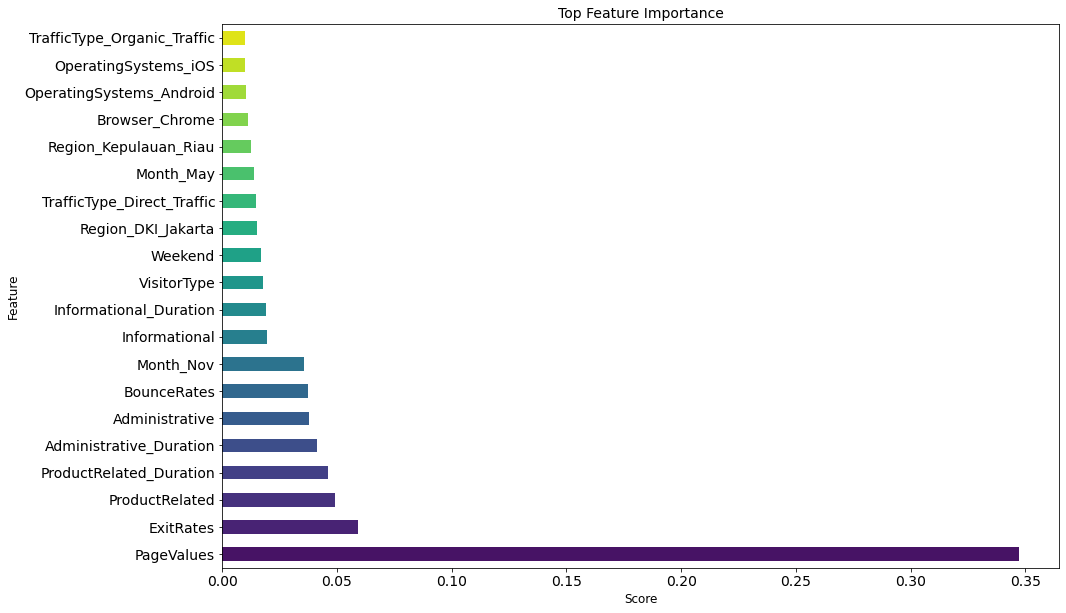

In [42]:
from sklearn.ensemble import ExtraTreesClassifier

# Define dataset
data = df_cleaned
# Assign X and y
X = data.drop('Purchase', axis = 1)
y = data['Purchase']

# Result count
n = 20

# Perform importance test
model = ExtraTreesClassifier()
model.fit(X, y)

plt.figure(figsize = (15, 10))
feat_importances = pd.Series(model.feature_importances_, index = X.columns)
feat_importances.nlargest(n).plot(kind = 'barh',
                                  color = sns.color_palette('viridis', 20))
plt.title('Top Feature Importance', fontsize = 14)
plt.xlabel('Score', fontsize = 12)
plt.ylabel('Feature', fontsize = 12)
plt.show()

Dari hasil Extra Trees Classifier, fitur `PageValues` memiliki skor tertinggi terhadap target, diikuti `ExitRates`, `ProductRelated`, `ProductRelated_Duration`, dan `Administrative_Duration`.

### 2.1.3. F-Classif 

In [43]:
from sklearn.feature_selection import f_classif

# Define dataset
data = df_cleaned
# Assign X and y
X = data.drop('Purchase', axis = 1)
y = data['Purchase']

# X is matrix feature, y is target feature
f_scores, p_values = f_classif(X, y)

X_result = pd.DataFrame({'Feature': X.columns, 'F-Score': f_scores, 'p-value': p_values})
X_result.sort_values('F-Score', ascending = False, inplace = True)

# Show top 5 the highest F-Score
X_result.head(5)

,Feature,F-Score,p-value
8,PageValues,13189.464674,0.000000e+00
7,ExitRates,2352.438804,0.000000e+00
5,ProductRelated_Duration,1626.094803,0.000000e+00
4,ProductRelated,1462.466214,8.158418e-307
6,BounceRates,1320.428954,2.527808e-278


### 2.1.4. ANOVA F-value-based Feature Selection (AF)

In [44]:
from sklearn.feature_selection import SelectKBest, f_classif

# Define dataset
data = df_cleaned
# Assign X and y
X = data.drop('Purchase', axis = 1)
y = data['Purchase']

# Perform importance test
selector = SelectKBest(score_func = f_classif)
selector.fit(X, y)

# Get selected feature indices
selected_features = selector.get_support(indices = True)

# Get names of selected features
selected_feature_names = X.columns[selected_features]

# Select only selected features
X_selected = X[selected_feature_names]
X_selected.sum().sort_values(ascending = False)

ProductRelated_Duration    11973.702023
ProductRelated             10125.643664
Administrative_Duration     6967.784789
Administrative              5975.773735
PageValues                  5465.695530
Month_Nov                   5151.000000
ExitRates                   3076.286335
Informational               2799.822362
Informational_Duration      2790.030921
BounceRates                 1440.910638
dtype: float64

In [45]:
X_selected.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'Month_Nov'],
      dtype='object')

Dari tiga metode _feature selection_ sebelumnya, nilai `PageValues` selalu menjadi yang tertinggi, tetapi ketika kami menggunakan metode ANOVA F-value-based Feature Selection (AF), nilai yang tertinggi dimiliki oleh fitur `ProductRelated_Duration`.

### 2.1.5. Correlation Matrix Method

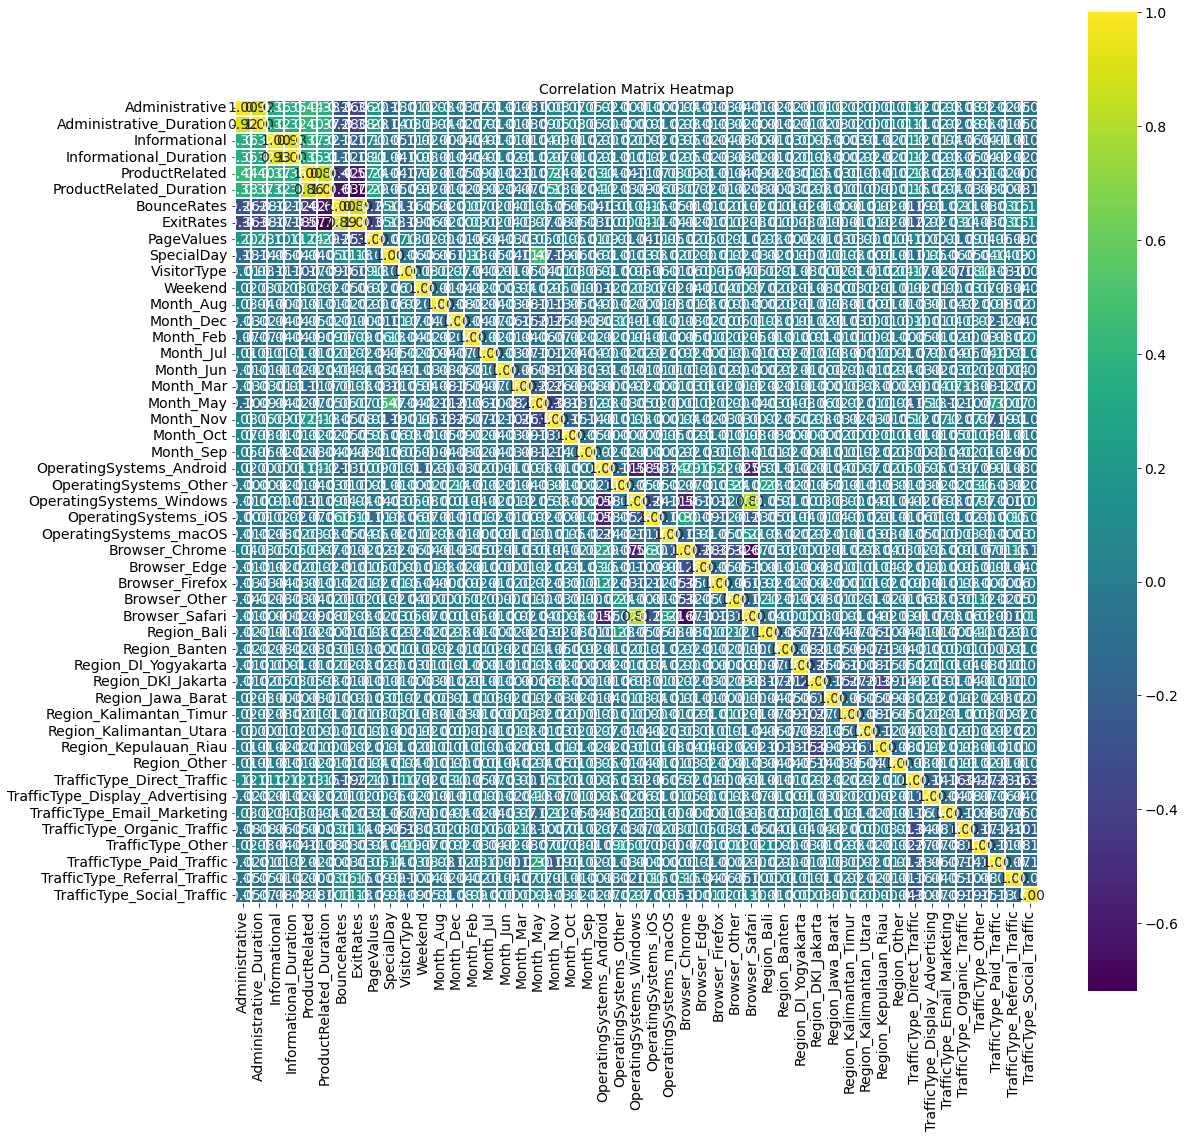

In [46]:
# Perform correlation matrix test
plt.figure(figsize=(18, 18))
sns.heatmap(X.corr(), annot = True, fmt = '.2f', cmap = 'viridis', linewidths = 0.005, square = True)
plt.title('Correlation Matrix Heatmap', fontsize = 14)
plt.show()

In [47]:
X.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'VisitorType',
       'Weekend', 'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul',
       'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct',
       'Month_Sep', 'OperatingSystems_Android', 'OperatingSystems_Other',
       'OperatingSystems_Windows', 'OperatingSystems_iOS',
       'OperatingSystems_macOS', 'Browser_Chrome', 'Browser_Edge',
       'Browser_Firefox', 'Browser_Other', 'Browser_Safari', 'Region_Bali',
       'Region_Banten', 'Region_DI_Yogyakarta', 'Region_DKI_Jakarta',
       'Region_Jawa_Barat', 'Region_Kalimantan_Timur',
       'Region_Kalimantan_Utara', 'Region_Kepulauan_Riau', 'Region_Other',
       'TrafficType_Direct_Traffic', 'TrafficType_Display_Advertising',
       'TrafficType_Email_Marketing', 'TrafficType_Organic_Traffic',
       'TrafficT

## 2.2. Feature Extraction

Kami mencari interaksi fitur dan melakukan agregasi terhadap beberapa fitur. Khususnya, kami ingin mencari kemungkinan interaksi fitur dengan `PageValues`, yang kami anggap penting untuk kasus ini.

| Feature Name | Feature Description | 
|:-------------|:--------------------------------------------------------------|
| `TotalPage_View`            | Sum of page views from `Administrative`, `Informational`, `ProductRelated` pages |
| `TotalPage_Time`            | Sum of page durations from `Administrative`, `Informational`, `ProductRelated` pages |
| `ProductView_Percent`       | Percentage of `ProductRelated` page views |
| `ProductTime_Percent`       | Percentage of `ProductRelated` page durations |
| `Average_ProductTime`       | Average duration per page for `ProductRelated` pages |
| `PageValues_x_BounceRates`  | `PageValues` $\times$ (1 - `BounceRates`) |
| `PageValues_per_ProductView`| `PageValues` per `ProductRelated` page views |
| `PageValues_per_ProductTime`| `PageValues` per `ProductRelated` page durations |

In [48]:
df['TotalPage_View'] = (df['Administrative'] +
                        df['Informational'] +
                        df['ProductRelated'])

In [49]:
df['TotalPage_Time'] = (df['Administrative_Duration'] +
                        df['Informational_Duration'] +
                        df['ProductRelated_Duration'])

Melakukan PCA (Principal Component Analysis) dengan tujuan mereduksi dimensi dengan membentuk fitur baru dengan menggabungkan fitur-fitur yang sudah ada.
- `TotalPage_view` sebuah fitur baru yang berisi informasi total halaman yang dilihat pengunjung selama mengunjungi web.
- `TotalPage_time` sebuah fitur baru yang berisi informasi total waktu yang dihabiskan pengunjung dalam mengunjungi web.

In [50]:
df['ProductView_Percent'] = df['ProductRelated'] / df['TotalPage_View'] * 100
df['ProductTime_Percent'] = df['ProductRelated_Duration'] / df['TotalPage_Time'] * 100
df['Average_ProductTime'] = df['ProductRelated_Duration'] / df['ProductRelated'] # Average time spent
df['PageValues_x_BounceRates'] = df['PageValues'] * (1 - df['BounceRates'])
df['PageValues_per_ProductView'] = df['PageValues'] / df['ProductRelated']
df['PageValues_per_ProductTime'] = df['PageValues'] / df['ProductRelated_Duration']

Untuk mempermudah ML dalam memprediksi, kami mencoba untuk menggali informasi data yang nantinya akan dibuat fitur baru.
- `ProductView_Percent` merupakan fitur yang berisi informasi persentase customer dalam melihat produk yang sejenis.
- `ProductTime_Percent` merupakan fitur yang berisi informasi persentase customer dalam menghabiskan waktu untuk melihat produk yang sejenis.
- `Average_ProductTime` merupakan fitur yang berisi informasi rata-rata waktu yang dihabiskan customer dalam melihat produk sejenis.
- `PageValues_x_BounceRates` merupakan fitur yang berisi informasi keterkaitan antara PageValues dan BounceRate, dimana jika nilainya semakin besar maka semakin baik sebuah halaman tersebut.
- `PageValues_per_ProductView` merupakan fitur yang berisi informasi rasio antara nilai halaman dan jumlah halaman produk sejenis, jika semakin tinggi nilainya maka bisa dikatakan halaman produk sejenis itu cenderung menciptakan transaksi.
- `PageValues_per_ProductTime` merupakan fitur yang berisi informasi rasio antara nilai halaman dan waktu yang dihabiskan untuk melihat produk sejenis, jika semakin tinggi nilainya maka customer tertarik pada produk yang ditawarkan dan cenderung melakukan transaksi setelah menghabiskan di halaman produk yang cukup lama.

In [51]:
nan_replacements = {'ProductView_Percent' : 0,
                    'ProductTime_Percent' : 0,
                    'Average_ProductTime' : 0,
                    'PageValues_x_BounceRates' : 0,
                    'PageValues_per_ProductView' : 0,
                    'PageValues_per_ProductTime' : 0}

# Correct values
df = df.fillna(nan_replacements)

In [52]:
df.sample(5)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Purchase,TotalPage_View,TotalPage_Time,ProductView_Percent,ProductTime_Percent,Average_ProductTime,PageValues_x_BounceRates,PageValues_per_ProductView,PageValues_per_ProductTime
5027,10,586.648019,3,263.666667,41,1919.24523,0.014876,0.031679,3.485353,0.0,May,Windows,Safari,Jawa_Barat,Display_Advertising,0,1,0,54,2769.559915,75.925926,69.297841,46.810859,3.433506,0.085009,0.001816
2526,0,0.000000,1,172.000000,21,564.50000,0.000000,0.042965,0.000000,0.8,May,iOS,Other,Kalimantan_Timur,Organic_Traffic,0,0,0,22,736.500000,95.454545,76.646300,26.880952,0.000000,0.000000,0.000000
6375,0,0.000000,0,0.000000,6,0.00000,0.200000,0.200000,0.000000,0.0,June,iOS,Chrome,Kalimantan_Utara,Referral_Traffic,0,0,0,6,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2524,11,79.750000,0,0.000000,31,419.25000,0.006818,0.026894,0.000000,0.8,May,Android,Chrome,DKI_Jakarta,Social_Traffic,0,0,0,42,499.000000,73.809524,84.018036,13.524194,0.000000,0.000000,0.000000
5997,0,0.000000,0,0.000000,8,20.20000,0.100000,0.175000,0.000000,0.0,June,iOS,Chrome,DKI_Jakarta,Organic_Traffic,0,0,0,8,20.200000,100.000000,100.000000,2.525000,0.000000,0.000000,0.000000
